In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pdb

torch.manual_seed(2222)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        n_input = 2
        n_output = 1
        n_nodes = 30

        self.hidden_layer1 = nn.Linear(n_input,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.normal_(self.hidden_layer1.bias)

        self.hidden_layer2 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.normal_(self.hidden_layer2.bias)

        self.hidden_layer3 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        nn.init.normal_(self.hidden_layer3.bias)

        self.hidden_layer4 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer4.weight)
        nn.init.normal_(self.hidden_layer4.bias)

        self.hidden_layer5 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer5.weight)
        nn.init.normal_(self.hidden_layer5.bias)

        self.hidden_layer6 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer6.weight)
        nn.init.normal_(self.hidden_layer6.bias)

        self.output_layer = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.normal_(self.output_layer.bias)

    def forward(self, x,y):
        inputs = torch.cat([x,y],axis=1)

        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        layer6_out = torch.tanh(self.hidden_layer6(layer5_out))

        output = self.output_layer(layer6_out)
        return output

In [ ]:
def pinnLoss(x,y, mse, net_u, net_v):

    u = net_u(x,y)
    v = net_v(x,y)

    # E = 1
    # nu = 0.3

    # lmbd = E * nu/((1+nu)*(1-2*nu))
    # mu = E/(2*(1+nu))

    #Alu
    # lmbd = 0.504
    # mu = 0.259

    #Steel
    lmbd = 1.076
    mu = 0.779

    #Copper
    # lmbd = 0.854
    # mu = 0.44

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    exx = u_x
    eyy = v_y
    exy = 1/2*(u_y + v_x)

    sxx = (lmbd+2*mu)*exx + lmbd*eyy
    syy = (lmbd+2*mu)*eyy + lmbd*exx
    sxy = 2*mu*exy

    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_x = torch.autograd.grad(sxy.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]

    Fx = (sxx_x + sxy_y)
    Fy = (sxy_x + syy_y) - 1

    mse_losspde= mse(Fx, torch.zeros_like(x)) + mse(Fy, torch.zeros_like(x))


    return mse_losspde, u, v, sxx, sxy, syy


In [ ]:
def dataPoints(x0,y0,x1,y1,nx,ny,densBnd):

    x = np.linspace(x0,x1,num = nx)
    y = np.linspace(y0,y1,num = ny)

    X, Y = np.meshgrid(x,y)

    xi = X[1:-1,1:-1].reshape(-1,1)
    yi = Y[1:-1,1:-1].reshape(-1,1)

    xb = np.linspace(x0,x1,num = densBnd * nx)
    yb = np.linspace(y0,y1,num = densBnd * ny)
    Xb, Yb = np.meshgrid(xb,yb)
    xb = np.hstack((Xb[:,0], Xb[-1,:],Xb[:,-1],Xb[0,:])).reshape(-1,1)
    yb = np.hstack((Yb[:,0], Yb[-1,:],Yb[:,-1],Yb[0,:])).reshape(-1,1)
    xt = np.vstack((xb,xi))
    yt = np.vstack((yb,yi))

    fig = plt.figure(figsize=(10,1.5))
    plt.scatter(xb,yb,s=2)
    plt.scatter(xi,yi,s=2)
    plt.show

    return xt, yt

In [ ]:
def boundaryPointsCantilever(x,y,x0,y0,x1,y1):

    Lx = x1 - x0
    Ly = y1 - y0

    # x = 0
    idxLeft = torch.where(x==x0)

    # x = Lx
    idxRight = torch.where(x==x1)

    # y = 0
    idxBot = torch.where(y==y0)

    # y = Ly
    idxTop = torch.where(y==y1)

    return idxLeft, idxBot, idxTop, idxRight

In [ ]:
def boundaryLoss(f, x, y, x0, y0, x1, y1, mse, net_u, net_v):

    def get_xy(idx):
        return x[idx].unsqueeze(1), y[idx].unsqueeze(1)

    # Left boundary
    xL, yL = get_xy(idxLeft)
    _, u_xL, v_xL, _, _, _ = pinnLoss(xL, yL, mse, net_u, net_v)

    # Top boundary
    xT, yT = get_xy(idxTop)
    _, _, _, _, sxy_T, syy_T = pinnLoss(xT, yT, mse, net_u, net_v)

    # Bottom boundary
    xB, yB = get_xy(idxBot)
    _, _, _, _, sxy_B, syy_B = pinnLoss(xB, yB, mse, net_u, net_v)

    # Right boundary
    xR, yR = get_xy(idxRight)
    _, u_xR, v_xR, _, _, _ = pinnLoss(xR, yR, mse, net_u, net_v)

    # Boundary condition losses
    loss = (
        mse(u_xL, torch.zeros_like(u_xL)) +
        mse(v_xL, torch.zeros_like(v_xL)) +

        mse(u_xR, torch.zeros_like(u_xR)) +
        mse(v_xR, torch.zeros_like(v_xR)) +

        mse(syy_T, f * torch.ones_like(syy_T)) +
        mse(sxy_T, torch.zeros_like(sxy_T)) +

        mse(syy_B, torch.zeros_like(syy_B)) +
        mse(sxy_B, torch.zeros_like(sxy_B))
    )

    return loss


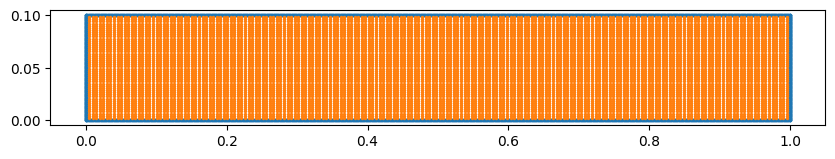

In [ ]:
x0 = 0
y0 = 0
x1 = 1
y1 = 0.1
g = 0 # load

nx = 200      # Points for x-axis
ny = 50      # Points for y-axis
densBnd = 10   # Distribution density of points on boundaries

xnp, ynp = dataPoints(x0,y0,x1,y1,nx,ny,densBnd)

In [ ]:
x = torch.tensor(xnp, dtype = torch.float32, requires_grad = True).to(device)
y = torch.tensor(ynp, dtype = torch.float32, requires_grad = True).to(device)

idxLeft, idxBot, idxTop, idxRightFree, idxRightLoad = boundaryPointsCantilever(x,y,x0,y0,x1,y1)

net_u = Net().to(device)
net_v = Net().to(device)

def u_hard(x, y):
    return x * (x - 1) * net_u(x, y)

def v_hard(x, y):
    return x * (x - 1) * net_v(x, y)

num_epochs = 10000
lr = 0.001
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(net_u.parameters()) + list(net_v.parameters()), lr = lr)

history = np.zeros((0,2))

In [ ]:
def plot_loss(losses, ylabel):
    epochs = len(losses)
    x_epochs = np.arange(1, epochs + 1)

    plt.figure()
    plt.plot(x_epochs, losses, color='blue')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.savefig('loss_his.png')
    plt.show()


loss_history = []

for epoch in range(2000):

    optimizer.zero_grad()

    mse_losspde, _, _, _, _, _ = pinnLoss(x, y, mse, net_u, net_v)

    mse_lossbc = boundaryLoss(f, x, y, x0, y0, x1, y1, mse, net_u, net_v)

    loss = mse_losspde + mse_lossbc

    loss.backward(retain_graph = True)
    optimizer.step()

    loss_history.append(loss.item())
    #with torch.autograd.no_grad():
    if (epoch+1) % 1000 == 0:
        print(epoch+1,"Traning Loss:",loss.item())
        print(f'PDE Loss: {mse_losspde:.4e}, BC Loss: {mse_lossbc:.4e}')


        ep = epoch + 1
plot_loss(loss_history, ylabel='Training Loss')




In [ ]:
def get_displacement_field(x, y, net_u, net_v):

    with torch.no_grad():
        u = net_u(x, y)
        v = net_v(x, y)

    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    u_np = u.detach().cpu().numpy()
    v_np = v.detach().cpu().numpy()

    return x_np, y_np, u_np, v_np

x_np, y_np, u_np, v_np = get_displacement_field(x, y, net_u, net_v)
x_def_np = x_np + u_np
y_def_np = y_np + v_np

# === Plot Deformed and original shapes ===
plt.figure(figsize=(10, 3))
plt.scatter(x_np, y_np, s=1, label='Original', alpha=0.3)
plt.scatter(x_def_np, y_def_np, s=1, label='Deformed', alpha=0.6)
plt.legend()
plt.title('Deformation of 2D Elastic Beam')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.show()


In [ ]:
stride = 20
x_plot = x_np[::stride]
y_plot = y_np[::stride]
u_plot = u_np[::stride]
v_plot = v_np[::stride]

scale_factor = 1
u_plot_scaled = u_plot * scale_factor
v_plot_scaled = v_plot * scale_factor

plt.figure(figsize=(20, 6))
plt.quiver(x_plot, y_plot, u_plot_scaled, v_plot_scaled,
           angles='xy', scale_units='xy', scale=1.0, color='blue', width=0.001)
plt.title('Displacement Vector Field (Scaled & Downsampled)')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

y_min, y_max = plt.ylim()

plt.ylim(bottom=y_min, top=y_max)
plt.grid(True)
plt.show()
